In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
from shapely.ops import unary_union
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.max_columns = 200

# Census Tract

In [4]:
# save this geo file
ct2010 = gpd.read_file('./Data/GeoBase/ct2010_geoid.geojson')
ct2010.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,GeoID,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,36085000900,"POLYGON ((-74.07921 40.64343, -74.07914 40.643..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200308,36061009800,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."
2,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,36061010200,"POLYGON ((-73.97124 40.76094, -73.97170 40.760..."
3,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,36061010400,"POLYGON ((-73.97446 40.76229, -73.97491 40.761..."
4,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860640,36061011300,"POLYGON ((-73.98412 40.75484, -73.98460 40.754..."


# Independent Variables

## Social & Economic


**Data Source:** ACS 5 years estimate

https://data.census.gov/cedsci/table?g=0500000US36005%241400000,36047%241400000,36061%241400000,36081%241400000,36085%241400000

**Geography:** Census Tract

**Date:** 2020

In [5]:
Pop = pd.read_csv('./Data/Social_Economic/ACSST5Y2020.S0101_2022-11-05T223402/ACSST5Y2020.S0101-Data.csv'
            , skiprows=1, usecols=['Geography'
                                   ,'Estimate!!Total!!Total population'
                                   ,'Estimate!!Total!!Total population!!SUMMARY INDICATORS!!Median age (years)']
                                   )
Pop.columns = ['GeoID', 'Pop', 'Age']
Pop.head()

,GeoID,Pop,Age
0,1400000US36005000100,6600,35.1
1,1400000US36005000200,4167,37.9
2,1400000US36005000400,5684,40.1
3,1400000US36005001600,5917,39.3
4,1400000US36005001901,1910,32.6


In [6]:
Income = pd.read_csv('./Data/Social_Economic/ACSST5Y2020.S1901_2022-11-05T225145/ACSST5Y2020.S1901-Data.csv'
            , skiprows=1, usecols=['Geography'
                                   ,'Estimate!!Households!!Median income (dollars)'
                                  ]
                                   )
Income.columns = ['GeoID', 'MIncome']
Income.head()

,GeoID,MIncome
0,1400000US36005000100,-
1,1400000US36005000200,68000
2,1400000US36005000400,93155
3,1400000US36005001600,34766
4,1400000US36005001901,61711


In [7]:
Employment = pd.read_csv('./Data/Social_Economic/ACSST5Y2020.S2301_2022-11-05T225451/ACSST5Y2020.S2301-Data.csv'
           ,skiprows=1
           ,usecols=['Geography'
                     ,'Estimate!!Unemployment rate!!Population 20 to 64 years'
                     ,"Estimate!!Employment/Population Ratio!!Population 16 years and over!!RACE AND HISPANIC OR LATINO ORIGIN!!White alone"
                     ,"Estimate!!Employment/Population Ratio!!EDUCATIONAL ATTAINMENT!!Population 25 to 64 years!!Bachelor's degree or higher"
                    ])

Employment.columns = ['GeoID', 'White', 'Bachelor_Degree', 'Unemployment']
Employment.head()

,GeoID,White,Bachelor_Degree,Unemployment
0,1400000US36005000100,0.0,0.0,-
1,1400000US36005000200,40.0,88.6,10.0
2,1400000US36005000400,67.8,92.0,4.3
3,1400000US36005001600,36.9,87.0,7.4
4,1400000US36005001901,79.0,96.0,3.6


In [8]:
Mode = pd.read_csv('./Data/Social_Economic/ACSDT5Y2020.B08301_2022-11-05T230847/ACSDT5Y2020.B08301-Data.csv'
           ,skiprows=1
           ,usecols=['Geography'
                     ,'Estimate!!Total:'
                     ,"Estimate!!Total:!!Public transportation (excluding taxicab):!!Subway or elevated rail"
                     ,"Estimate!!Total:!!Bicycle"
                    ])

Mode.columns = ['GeoID', 'Total', 'M_Subway', 'M_Bike']

Mode['M_Subway'] = Mode['M_Subway']/Mode['Total']
Mode['M_Bike'] = Mode['M_Bike']/Mode['Total']

Mode = Mode.drop(columns=['Total'])

Mode.head()

,GeoID,M_Subway,M_Bike
0,1400000US36005000100,NaN,NaN
1,1400000US36005000200,0.287821,0.000000
2,1400000US36005000400,0.261804,0.004559
3,1400000US36005001600,0.277778,0.009333
4,1400000US36005001901,0.365403,0.014577


In [9]:
Vehicle = pd.read_csv('./Data/Social_Economic/ACSDT5Y2020.B25044_2022-11-05T231628/ACSDT5Y2020.B25044-Data.csv'
           ,skiprows=1
           ,usecols=['Geography'
                     ,'Estimate!!Total:'
                     ,"Estimate!!Total:!!Owner occupied:!!No vehicle available"
                     ,"Estimate!!Total:!!Renter occupied:!!No vehicle available"
                    ])

Vehicle.columns = ['GeoID', 'Total', 'Owner', 'Renter']

Vehicle['NoVehicle'] = (Vehicle['Owner'] + Vehicle['Renter'])/Vehicle['Total']

Vehicle = Vehicle[['GeoID','NoVehicle']]

Vehicle.head()

,GeoID,NoVehicle
0,1400000US36005000100,NaN
1,1400000US36005000200,0.224627
2,1400000US36005000400,0.208531
3,1400000US36005001600,0.597771
4,1400000US36005001901,0.605867


In [10]:
# merge
Social_Economic = Pop.merge(Income).merge(Employment).merge(Mode).merge(Vehicle)
Social_Economic['GeoID'] = Social_Economic['GeoID'].map(lambda x: x.split('US',1)[1]).astype('int')

for i in Social_Economic.columns:
    Social_Economic[i] = pd.to_numeric(Social_Economic[i], errors='coerce')

Social_Economic = Social_Economic.dropna()
Social_Economic

,GeoID,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle
1,36005000200,4167,37.9,68000.0,40.0,88.6,10.0,0.287821,0.000000,0.224627
2,36005000400,5684,40.1,93155.0,67.8,92.0,4.3,0.261804,0.004559,0.208531
3,36005001600,5917,39.3,34766.0,36.9,87.0,7.4,0.277778,0.009333,0.597771
4,36005001901,1910,32.6,61711.0,79.0,96.0,3.6,0.365403,0.014577,0.605867
5,36005001902,1334,30.9,53882.0,71.8,91.8,8.0,0.721667,0.000000,0.623100
...,...,...,...,...,...,...,...,...,...,...
2321,36085030301,5151,42.0,89777.0,62.1,86.5,3.1,0.004458,0.000000,0.089677
2322,36085030302,6569,35.8,90979.0,60.4,81.1,5.8,0.011372,0.000000,0.086999
2323,36085031901,3293,31.9,40313.0,34.7,91.2,16.2,0.137386,0.014988,0.614991
2324,36085031902,4953,32.6,71000.0,55.2,82.1,2.6,0.023016,0.000000,0.318533


In [11]:
Social_Economic.dtypes

GeoID                int64
Pop                  int64
Age                float64
MIncome            float64
White              float64
Bachelor_Degree    float64
Unemployment       float64
M_Subway           float64
M_Bike             float64
NoVehicle          float64
dtype: object

### BE_LandUseMix: 

**Description:** Land-Use mix of commercial, residential (Employment and household entropy)

**Data Source:** SmartLocationDatabaseV3

https://www.epa.gov/smartgrowth/smart-location-mapping#SLD

**Geography:** Census Block/Census Tract
**Date:** 2021

In [12]:
# data at block level
SLD = gpd.read_file('./Data/Social_Economic/SmartLocationDatabaseV3/SmartLocationData.shp')
SLD.head()

,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,CBSA_Name,CBSA_POP,CBSA_EMP,CBSA_WRK,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,TotPop,CountHU,HH,P_WrkAge,AutoOwn0,Pct_AO0,AutoOwn1,Pct_AO1,AutoOwn2p,Pct_AO2p,Workers,R_LowWageW,R_MedWageW,R_HiWageWk,R_PCTLOWWA,TotEmp,E5_Ret,E5_Off,E5_Ind,E5_Svc,E5_Ent,E8_Ret,E8_off,E8_Ind,E8_Svc,E8_Ent,E8_Ed,E8_Hlth,E8_Pub,E_LowWageW,E_MedWageW,E_HiWageWk,E_PctLowWa,D1A,D1B,D1C,D1C5_RET,D1C5_OFF,D1C5_IND,D1C5_SVC,D1C5_ENT,D1C8_RET,D1C8_OFF,D1C8_IND,D1C8_SVC,D1C8_ENT,D1C8_ED,D1C8_HLTH,D1C8_PUB,D1D,D1_FLAG,D2A_JPHH,D2B_E5MIX,D2B_E5MIXA,D2B_E8MIX,D2B_E8MIXA,D2A_EPHHM,D2C_TRPMX1,D2C_TRPMX2,D2C_TRIPEQ,D2R_JOBPOP,D2R_WRKEMP,D2A_WRKEMP,D2C_WREMLX,D3A,D3AAO,D3AMM,D3APO,D3B,D3BAO,D3BMM3,D3BMM4,D3BPO3,D3BPO4,D4A,D4B025,D4B050,D4C,D4D,D4E,D5AR,D5AE,D5BR,D5BE,D5CR,D5CRI,D5CE,D5CEI,D5DR,D5DRI,D5DE,D5DEI,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Region,Households,Workers_1,Residents,Drivers,Vehicles,White,Male,Lowwage,Medwage,Highwage,W_P_Lowwag,W_P_Medwag,W_P_Highwa,GasPrice,logd1a,logd1c,logd3aao,logd3apo,d4bo25,d5dei_1,logd4d,UPTpercap,B_C_consta,B_C_male,B_C_ld1c,B_C_drvmve,B_C_ld1a,B_C_ld3apo,B_C_inc1,B_C_gasp,B_N_consta,B_N_inc2,B_N_inc3,B_N_white,B_N_male,B_N_drvmve,B_N_gasp,B_N_ld1a,B_N_ld1c,B_N_ld3aao,B_N_ld3apo,B_N_d4bo25,B_N_d5dei,B_N_UPTpc,C_R_Househ,C_R_Pop,C_R_Worker,C_R_Driver,C_R_Vehicl,C_R_White,C_R_Male,C_R_Lowwag,C_R_Medwag,C_R_Highwa,C_R_DrmV,NonCom_VMT,Com_VMT_Pe,VMT_per_wo,VMT_tot_mi,VMT_tot_ma,VMT_tot_av,GHG_per_wo,Annual_GHG,SLC_score,Shape_Leng,Shape_Area,geometry
0,1.0,481130078254,481130078254,48,113,007825,4,206,"Dallas-Fort Worth, TX-OK",19100,"Dallas-Fort Worth-Arlington, TX",7189384.0,3545715.0,3364458.0,73.595028,0.0,73.595028,73.595028,1202,460.0,423.0,0.549,69,0.163121,39,0.092199,315,0.744681,412,99,122,191,0.240291,66,20,3,0,19,24,20,3,0,15,24,0,4,0,21,27,18,0.318182,6.250422,16.332625,0.896800,0.271757,0.040764,0.000000,0.258170,0.326109,0.271757,0.040764,0.000000,0.203818,0.326109,0.000000,0.054351,0.0,7.147222,0.0,0.156028,0.886264,0.763386,0.855442,0.662091,0.348912,0.526296,0.585916,0.287128,0.104101,0.276151,6.242424,5.287423e-03,23.534900,0.000000,10.655277,12.879623,115.981747,0.000000,60.873677,8.696240,34.784958,43.481198,362.10,0.0,0.000000,4.33,37.654717,0.003602,433601.0,303660.0,135362.0,53504.0,0.000398,0.785893,0.000358,0.841299,0.000525,0.184697,0.000476,0.137707,6.0,14.0,15.0,17.0,14.000000,"Dallas-Fort Worth-Arlington, TX Metro Area",444.0,412.0,1141.0,660.88,648.0,455.0,687.0,99.0,122.0,191.0,0.318182,0.409091,0.272727,213.0,1.981060,0.640168,0.000000,2.630422,0.0,0.0,4.0,11.0,0.962706,-0.027509,-0.083530,-0.241761,-0.018226,-0.145805,-0.068564,0.012247,2.113264,0.328856,0.232304,0.030571,0.026792,0.093403,0.000627,-0.091362,-0.091362,-0.034381,-0.330840,-0.648986,-0.328734,0.023496,928341.0,2606868.0,1163871.0,1759309.2,1394052.0,0.29134,0.493078,0.213768,0.339558,0.446673,0.393452,5.807667,21.688738,27.496405,11.442995,82.636303,25.659327,24.499297,6369.817221,77.450956,3110.360820,297836.083090,"POLYGON ((-68983.316 1091325.734, -68981.266 1..."
1,2.0,481130078252,481130078252,48,113,007825,2,206,"Dallas-Fort Worth, TX-OK",19100,"Dallas-Fort Worth-Arlington, TX",7189384.0,3545715.0,3364458.0,119.829909,0.0,119.829909,119.214200,710,409.0,409.0,0.466,0,0.000000,168,0.410758,241,0.589242,395,76,107,212,0.192405,25,7,0,3,15,0,7,0,3,13,0,0,2,0,10,4,11,0.400000,3.430799,5.955666,0.209707,0.058718,0.000000,0.025165,0.125824,0.000000,0.058718,0.000000,0.025165,0.109047,0.000000,0.000000,0.016777,0.0,3.640506,0.0,0.061125,0.835015,0.569986,0.831686,0.554458,0.197047,0.248481,0.271309,0.002033,0.068027,0.119048,15.800000,3.736299e-07,22.893366,0.755137,2.859482,19.278747,80.145600,5.340904,10.681807,10.681807,85.454458,5.340904,718.84,0.0,0.009516,4.33,23.126113,0.006099,386504.0,272135.0,236885.0,90089.0,0.000355,0.700531,0.000321,0.753958,0.000919,0.323221,0.000801,0.231868,3.0,10.0,12.0,14.0,10.833333,"Dallas-Fort Worth-Ar

In [13]:
SLDNY = SLD[['GEOID10','D2A_EPHHM']]
SLDNY['GEOID10'] = SLDNY['GEOID10'].astype('str')
SLDNY['GeoID'] = SLDNY['GEOID10'].str[:-1]
SLDNY['GeoID'] = SLDNY['GeoID'].astype('int')
SLDNY = SLDNY[SLDNY.GeoID.isin(ct2010.GeoID)]
SLDNY.head()

,GEOID10,D2A_EPHHM,GeoID
148836,360810259002,0.813842,36081025900
148837,360810166002,0.449212,36081016600
148838,360811227021,0.000000,36081122702
148839,360810283005,0.320219,36081028300
148840,360811483004,0.626858,36081148300


In [14]:
BE_LandUseMix = SLDNY.groupby('GeoID').agg({'D2A_EPHHM':'mean'}).rename(columns={'D2A_EPHHM':'LandUseMix'}).reset_index()

In [15]:
BE_LandUseMix

,GeoID,LandUseMix
0,36005000100,0.000000
1,36005000200,0.160274
2,36005000400,0.392961
3,36005001600,0.442828
4,36005001900,0.461624
...,...,...
2160,36085030302,0.384364
2161,36085031901,0.352472
2162,36085031902,0.327844
2163,36085032300,0.432966


In [16]:
Social_Economic = Social_Economic.merge(BE_LandUseMix)
Social_Economic

,GeoID,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle,LandUseMix
0,36005000200,4167,37.9,68000.0,40.0,88.6,10.0,0.287821,0.000000,0.224627,0.160274
1,36005000400,5684,40.1,93155.0,67.8,92.0,4.3,0.261804,0.004559,0.208531,0.392961
2,36005001600,5917,39.3,34766.0,36.9,87.0,7.4,0.277778,0.009333,0.597771,0.442828
3,36005002300,4517,35.8,24474.0,22.4,55.1,12.0,0.553641,0.000000,0.829776,0.418240
4,36005002500,5694,32.0,27196.0,60.9,66.9,9.6,0.621647,0.024471,0.869048,0.284687
...,...,...,...,...,...,...,...,...,...,...,...
1950,36085030301,5151,42.0,89777.0,62.1,86.5,3.1,0.004458,0.000000,0.089677,0.540834
1951,36085030302,6569,35.8,90979.0,60.4,81.1,5.8,0.011372,0.000000,0.086999,0.384364
1952,36085031901,3293,31.9,40313.0,34.7,91.2,16.2,0.137386,0.014988,0.614991,0.352472
1953,36085031902,4953,32.6,71000.0,55.2,82.1,2.6,0.023016,0.000000,0.318533,0.327844


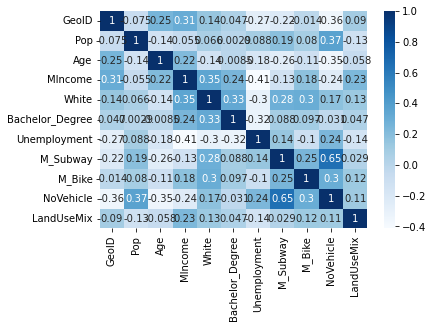

In [17]:
corr = Social_Economic.corr()
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

In [21]:
Social_Economic = Social_Economic.merge(ct2010[['GeoID','geometry']], on='GeoID')
Social_Economic

,GeoID,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle,LandUseMix,geometry
0,36005000200,4167,37.9,68000.0,40.0,88.6,10.0,0.287821,0.000000,0.224627,0.160274,"POLYGON ((-73.85652 40.80524, -73.85652 40.805..."
1,36005000400,5684,40.1,93155.0,67.8,92.0,4.3,0.261804,0.004559,0.208531,0.392961,"POLYGON ((-73.84611 40.81310, -73.84647 40.812..."
2,36005001600,5917,39.3,34766.0,36.9,87.0,7.4,0.277778,0.009333,0.597771,0.442828,"POLYGON ((-73.85514 40.82244, -73.85497 40.821..."
3,36005002300,4517,35.8,24474.0,22.4,55.1,12.0,0.553641,0.000000,0.829776,0.418240,"POLYGON ((-73.92289 40.80911, -73.92324 40.808..."
4,36005002500,5694,32.0,27196.0,60.9,66.9,9.6,0.621647,0.024471,0.869048,0.284687,"POLYGON ((-73.91750 40.80681, -73.91765 40.806..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1950,36085030301,5151,42.0,89777.0,62.1,86.5,3.1,0.004458,0.000000,0.089677,0.540834,"POLYGON ((-74.14623 40.62493, -74.14650 40.624..."
1951,36085030302,6569,35.8,90979.0,60.4,81.1,5.8,0.011372,0.000000,0.086999,0.384364,"POLYGON ((-74.16050 40.62653, -74.16024 40.626..."
1952,36085031901,3293,31.9,40313.0,34.7,91.2,16.2,0.137386,0.014988,0.614991,0.352472,"POLYGON ((-74.16050 40.62653, -74.16118 40.626..."
1953,36085031902,4953,32.6,71000.0,55.2,82.1,2.6,0.023016,0.000000,0.318533,0.327844,"POLYGON ((-74.16022 40.63834, -74.16015 40.638..."


In [27]:
Social_Economic = gpd.GeoDataFrame(Social_Economic, geometry=Social_Economic['geometry'])

In [30]:
# save file
Social_Economic.to_file("./Data/Social_Economic/Social_Economic.geojson", driver='GeoJSON')